In [1]:
import seesaw

In [2]:
import os
import importlib
import numpy as np
from tqdm.auto import tqdm

In [3]:
import os

In [4]:
import ray

In [5]:
ray.init('auto', namespace='seesaw', log_to_driver=False)

2022-02-16 09:30:29,132	INFO worker.py:842 -- Connecting to existing Ray cluster at address: 172.31.132.114:6379


{'node_ip_address': '172.31.132.114',
 'raylet_ip_address': '172.31.132.114',
 'redis_address': '172.31.132.114:6379',
 'object_store_address': '/state/partition1/user/omoll/raytmp/session_2022-02-16_08-46-35_255265_87189/sockets/plasma_store',
 'raylet_socket_name': '/state/partition1/user/omoll/raytmp/session_2022-02-16_08-46-35_255265_87189/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/state/partition1/user/omoll/raytmp/session_2022-02-16_08-46-35_255265_87189',
 'metrics_export_port': 62310,
 'node_id': 'ac3f39a038c5af0ca4b75f77a5146d74cdea6115739d554c74849982'}

In [6]:
import seesaw.seesaw_bench
import seesaw.figures

importlib.reload(seesaw)
importlib.reload(seesaw.seesaw_bench)
importlib.reload(seesaw.figures)
importlib.reload(seesaw.dataset_search_terms)
importlib.reload(seesaw.metrics)

from seesaw.metrics import *
from seesaw.seesaw_bench import *
from seesaw.figures import *

In [7]:
past_results = [
# ('', '/home/gridsan/omoll/bench_results/bench_eRpeMDdDBf/'),
# ('', '/home/gridsan/omoll/bench_results/bench_classic4/'),
# ('less_rounds', '/home/gridsan/omoll/bench_results/bench_less_rounds_npKQoAJulo/'),
('new_prompts', '/home/gridsan/omoll/bench_results/bench_better_prompt_pnwSMiDyxo/'),
# ('margin00', '/home/gridsan/omoll/bench_results/bench_smaller_margin_XAxsiXDCNB/'),
('margin01', '/home/gridsan/omoll/bench_results/bench_smaller_margin_ifTcCJRibe/'),
# ('less_zoom', '/home/gridsan/omoll/bench_results/bench_less_zoom_IXCKSUXQhL/'),
# ('test_temp_bias', '/home/gridsan/omoll/bench_results/bench_dynamic_linear_KWDekrrtFM/')
# ('temp_bias_only', '/home/gridsan/omoll/bench_results/bench_dynamic_linear2_zCTYSFRjeG/'),
# ('temp_bias_weight', '/home/gridsan/omoll/bench_results/bench_dynamic_linear3_xrYgEJigek/'),
('with_agg_method', '/home/gridsan/omoll/bench_results/bench_textual_linear_xxLhBtKjfY/'),
    ('reimpl',    '/home/gridsan/omoll/bench_results/bench_textual_implv2_sTuONGcAhf/')
]

In [8]:
# conclusions for now: prompting "a " does not make a different in object. seems to affect lvis worse.
# textual feedback helps

In [9]:
summs = []
for (mem, path) in past_results:
    df = get_all_session_summaries(path)
    if mem != '':
        df = df.assign(name=df.name + f'_{mem}')
    summs.append(df)

Map Progress: 100%|██████████| 200/200 [00:12<00:00, 16.18it/s]


0it [00:00, ?it/s]

In [10]:
summ = pd.concat(summs, axis=0, ignore_index=True)

In [11]:
summ = summ.assign(dataset=summ.d_name,
                    index_name=summ.i_name,
                    category=summ.ground_truth_category,
                    query_string=summ.qstr,
                    frequency=summ['ntotal']/summ['nimages'],
                    variant=summ.name)

In [24]:
def full_variant(row):
    (variant,mode) = row
    if mode is not None:
        return f'{variant}_{mode}'
    else:
        return  variant

summ = summ.assign(tvariant=summ.method_config.map(lambda c : None if c is None else c.get('mode', None)))
summ = summ.assign(variant=summ[['variant', 'tvariant']].apply(tuple, axis=1).map(full_variant))


In [25]:
stats = compute_stats(summ)

In [26]:
stats.groupby(['dataset', 'variant']).size().unstack(level=1).transpose().sort_index()

dataset                         data/lvis/  data/objectnet/
variant                                                    
baseline_new_prompts                  1203              313
multi_avg_vec_reimpl                  1203              313
multi_avg_vec_with_agg_method         1203              313
multi_new_prompts                     1203              313
multi_reimpl                          1203              313
multi_with_agg_method                 1203              313
seesaw_new_prompts                    1203              313
textual_linear_with_agg_method        1203              313
textual_multi_margin01                1203              313
textual_multi_new_prompts             1202              313
textual_reimpl_finetune               1203              313
textual_reimpl_linear                 1203              313

In [14]:
# plot = plot_compare(stats, 'multi_new_prompts', 'baseline_new_prompts', 'ndcg_score')
# plot

In [36]:
# plot = plot_compare(stats, 'multi_avg_vec_reimpl', 'multi_new_prompts', 'rank_last')
# plot

better  same  worse  neither  total
dataset                                             
data/lvis/           75  1075     53        0   1203
data/objectnet/      18   279     16        0    313
total                93  1354     69        0   1516

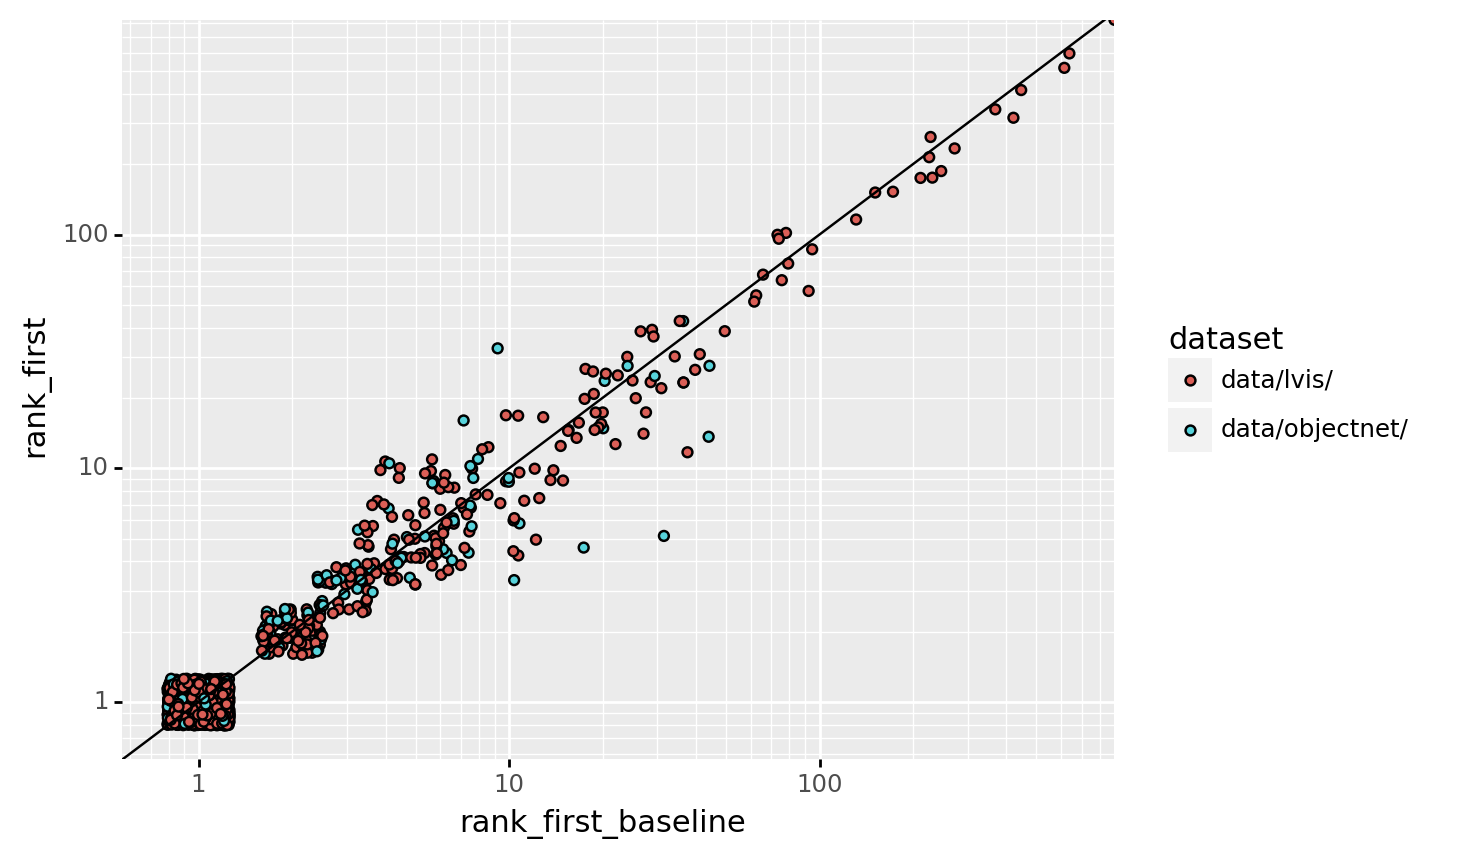

<ggplot: (8777408635112)>

In [39]:
plot = plot_compare(stats, 'textual_reimpl_finetune', 'multi_reimpl', 'rank_first')
plot

better  same  worse  neither  total
dataset                                             
data/lvis/           82  1068     53        0   1203
data/objectnet/      17   278     18        0    313
total                99  1346     71        0   1516

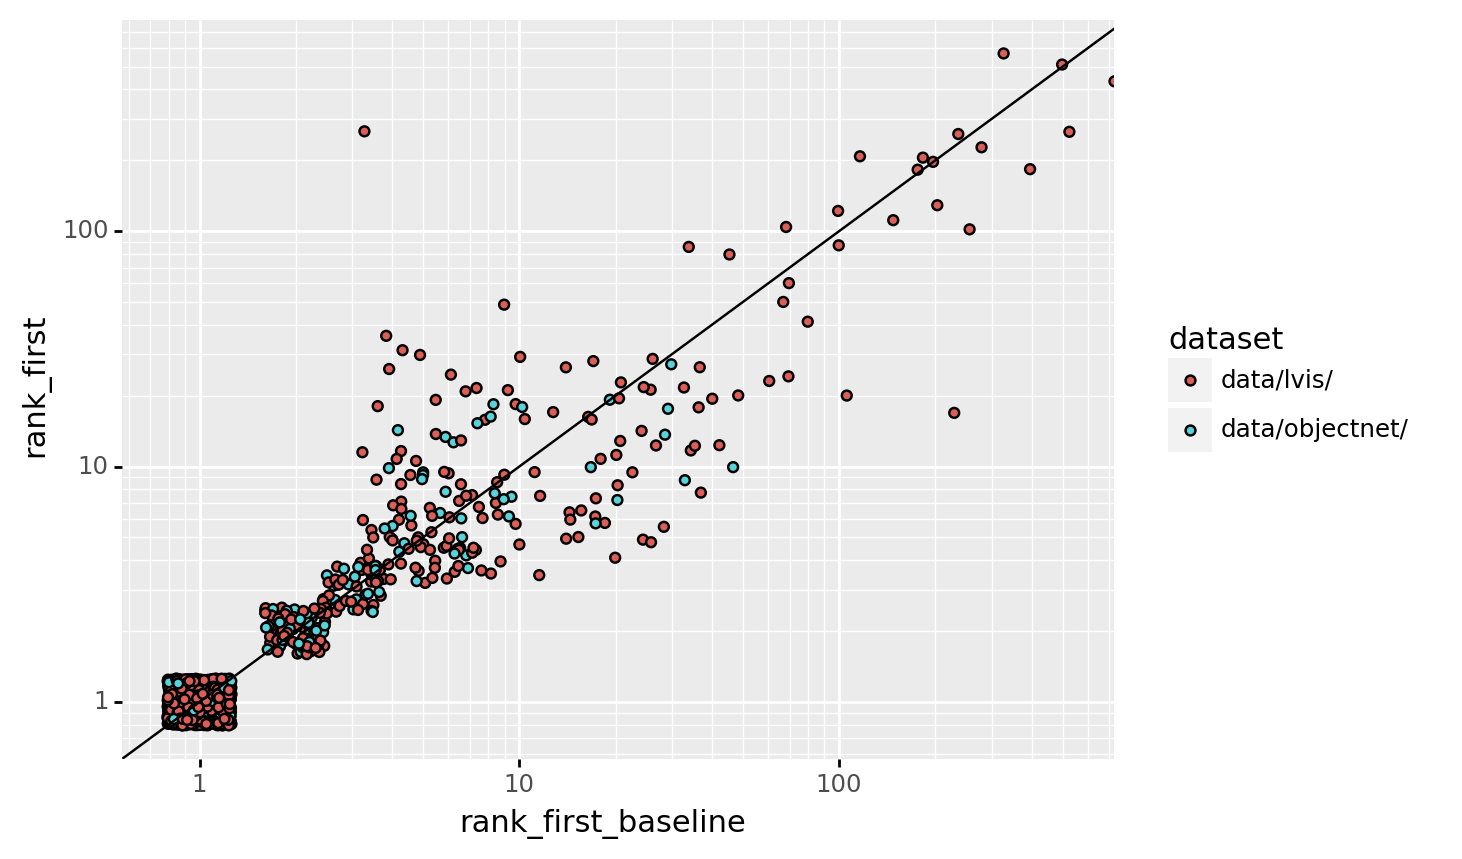

<ggplot: (8777408548858)>

In [40]:
plot = plot_compare(stats, 'textual_reimpl_linear', 'multi_reimpl', 'rank_first')
plot

better  same  worse  neither  total
dataset                                             
data/lvis/          377   641    185        0   1203
data/objectnet/     118   130     65        0    313
total               495   771    250        0   1516

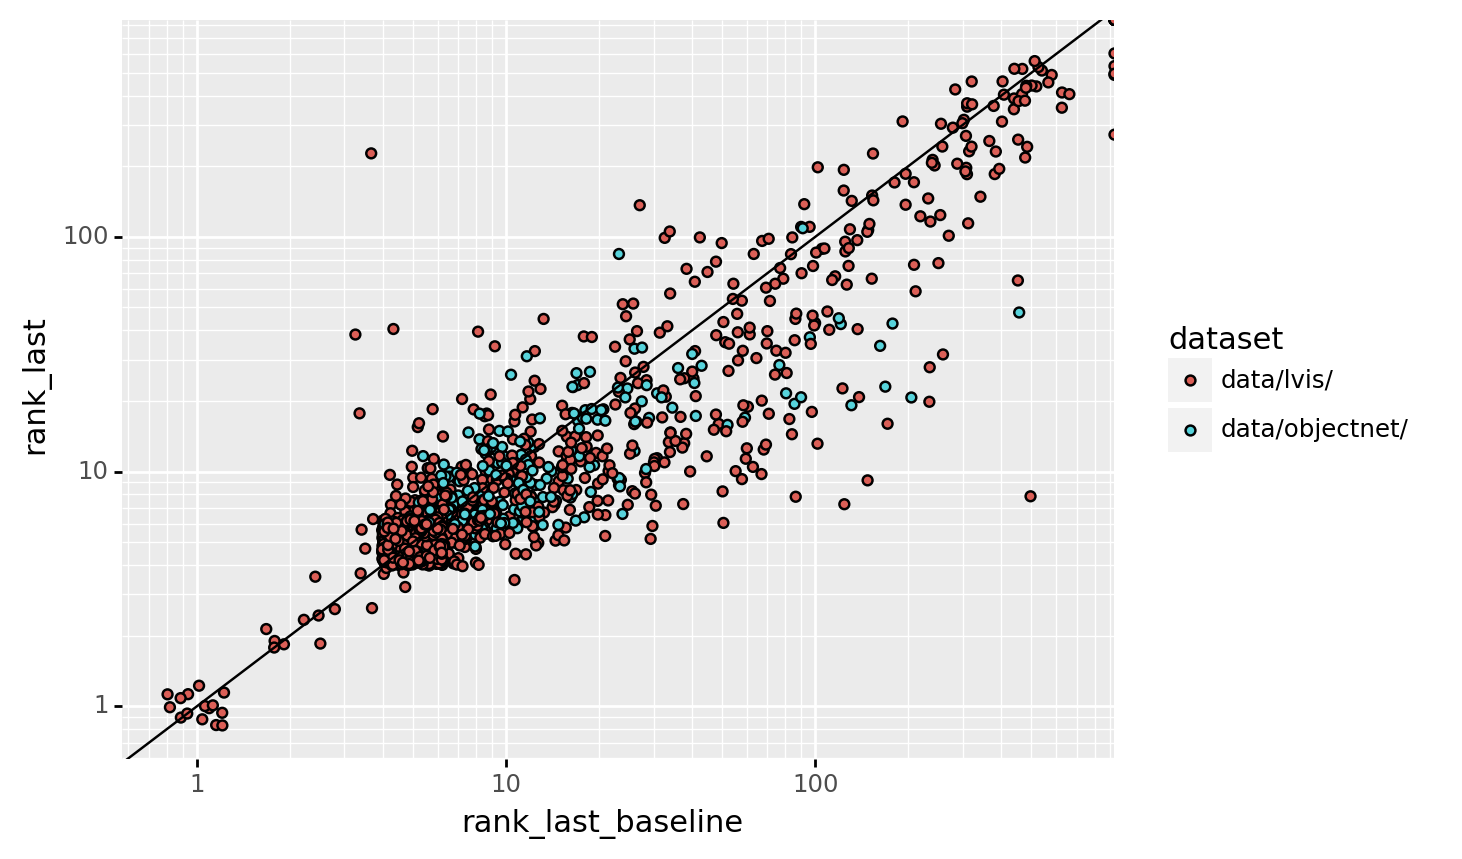

<ggplot: (8777408464360)>

In [41]:
plot = plot_compare(stats, 'textual_reimpl_linear', 'multi_reimpl', 'rank_last')
plot

better  same  worse  neither  total
dataset                                             
data/lvis/          326   657    220        0   1203
data/objectnet/     121   135     57        0    313
total               447   792    277        0   1516

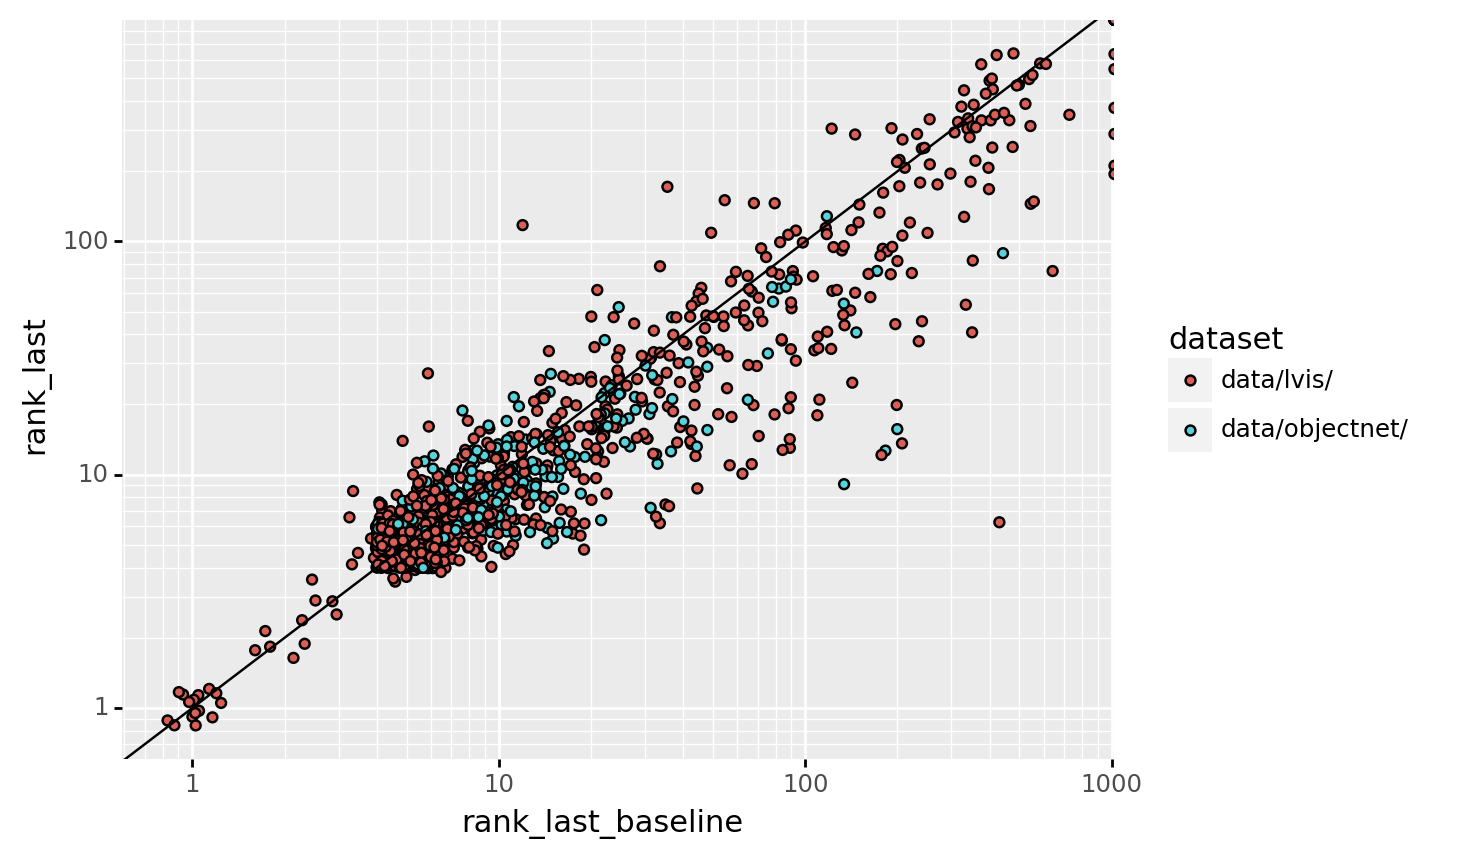

<ggplot: (8777408325864)>

In [43]:
plot = plot_compare(stats, 'textual_reimpl_finetune', 'multi_reimpl', 'rank_last')
plot

better  same  worse  neither  total
dataset                                             
data/lvis/          402   567    234        0   1203
data/objectnet/     132   118     63        0    313
total               534   685    297        0   1516

/state/partition1/llgrid/pkg/anaconda/anaconda3-2021b/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10


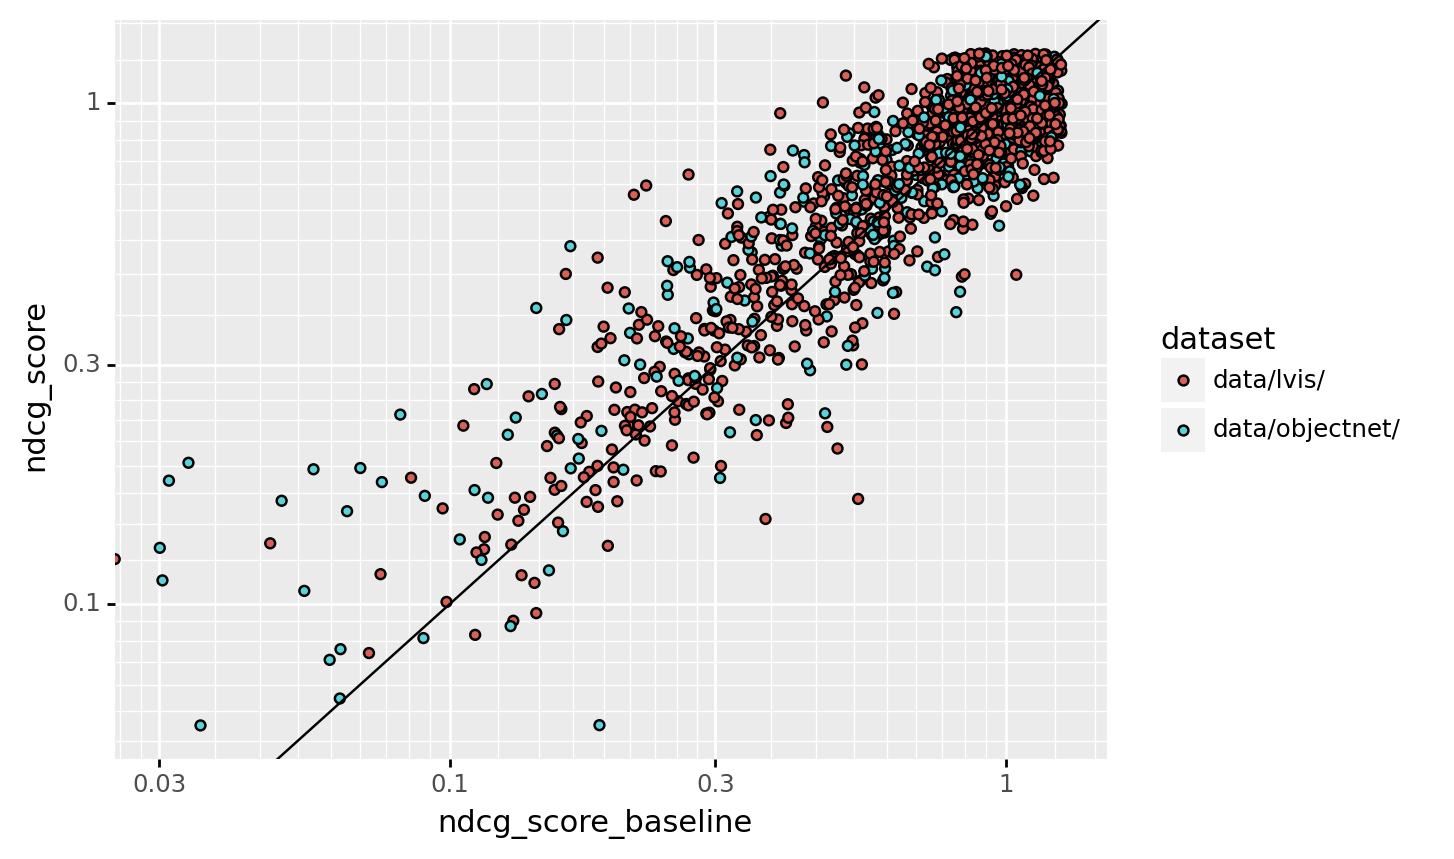

<ggplot: (8777408243173)>

In [44]:
plot = plot_compare(stats, 'textual_reimpl_linear', 'multi_reimpl', 'ndcg_score')
plot

better  same  worse  neither  total
dataset                                             
data/lvis/          378   578    247        0   1203
data/objectnet/     131   117     65        0    313
total               509   695    312        0   1516

/state/partition1/llgrid/pkg/anaconda/anaconda3-2021b/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10


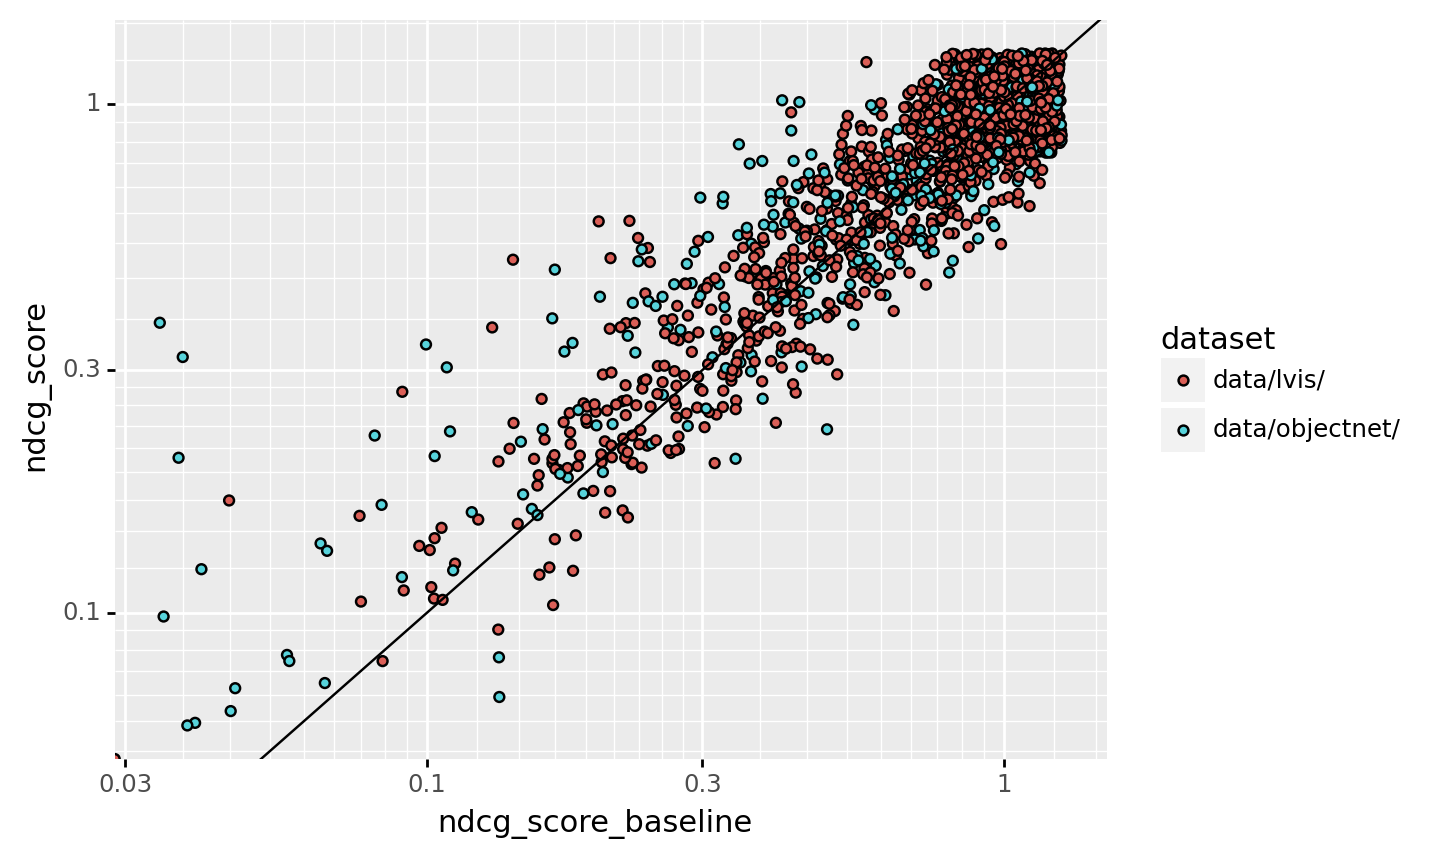

<ggplot: (8777408159211)>

In [46]:
plot = plot_compare(stats, 'textual_reimpl_finetune', 'multi_reimpl', 'ndcg_score')
plot

better  same  worse  neither  total
dataset                                             
data/lvis/          208   632    362        0   1202
data/objectnet/     119   126     68        0    313
total               327   758    430        0   1515

/state/partition1/llgrid/pkg/anaconda/anaconda3-2021b/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10


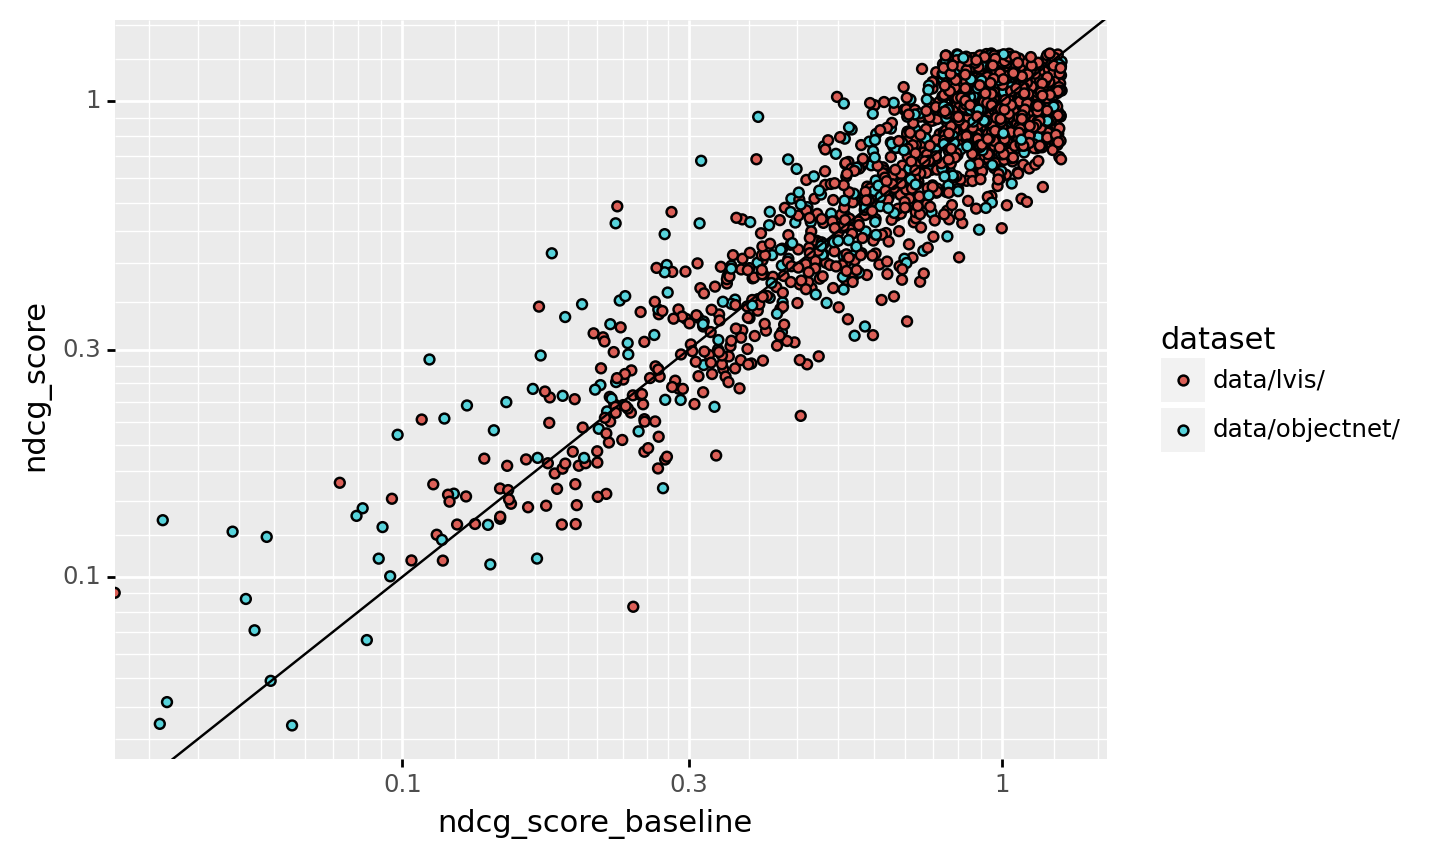

<ggplot: (8760569776716)>

In [32]:
plot = plot_compare(stats, 'textual_multi_new_prompts', 'seesaw_new_prompts', 'ndcg_score')
plot

In [ ]:
plot = plot_compare(stats, 'textual_multi_new_prompts', 'seesaw_new_prompts', 'ndcg_score')
plot

In [25]:
plot = plot_compare(stats, 'textual_multi_new_prompts', 'multi_new_prompts', 'rank_first')

better  same  worse  neither  total
dataset                                             
data/lvis/           61  1091     50        0   1202
data/objectnet/      17   283     13        0    313
total                78  1374     63        0   1515

better  same  worse  neither  total
dataset                                             
data/lvis/          127   980     96        0   1203
data/objectnet/       0   312      1        0    313
total               127  1292     97        0   1516

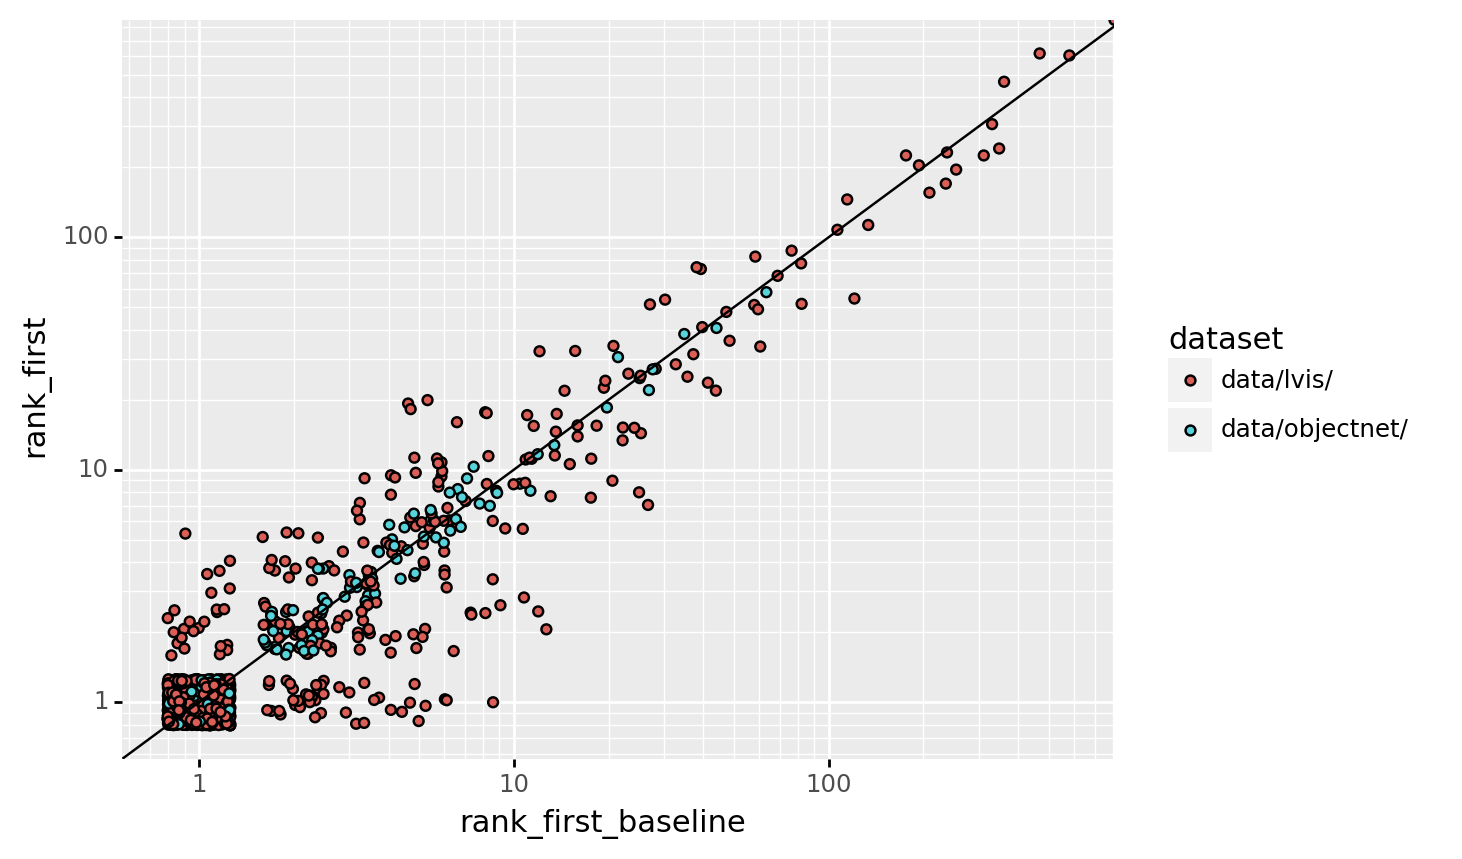

<ggplot: (8776983966708)>

In [17]:
plot = plot_compare(stats, 'multi_avg_vec_with_agg_method', 'multi_with_agg_method', 'rank_first')
plot

better  same  worse  neither  total
dataset                                             
data/lvis/           81  1068     54        0   1203
data/objectnet/      17   278     18        0    313
total                98  1346     72        0   1516

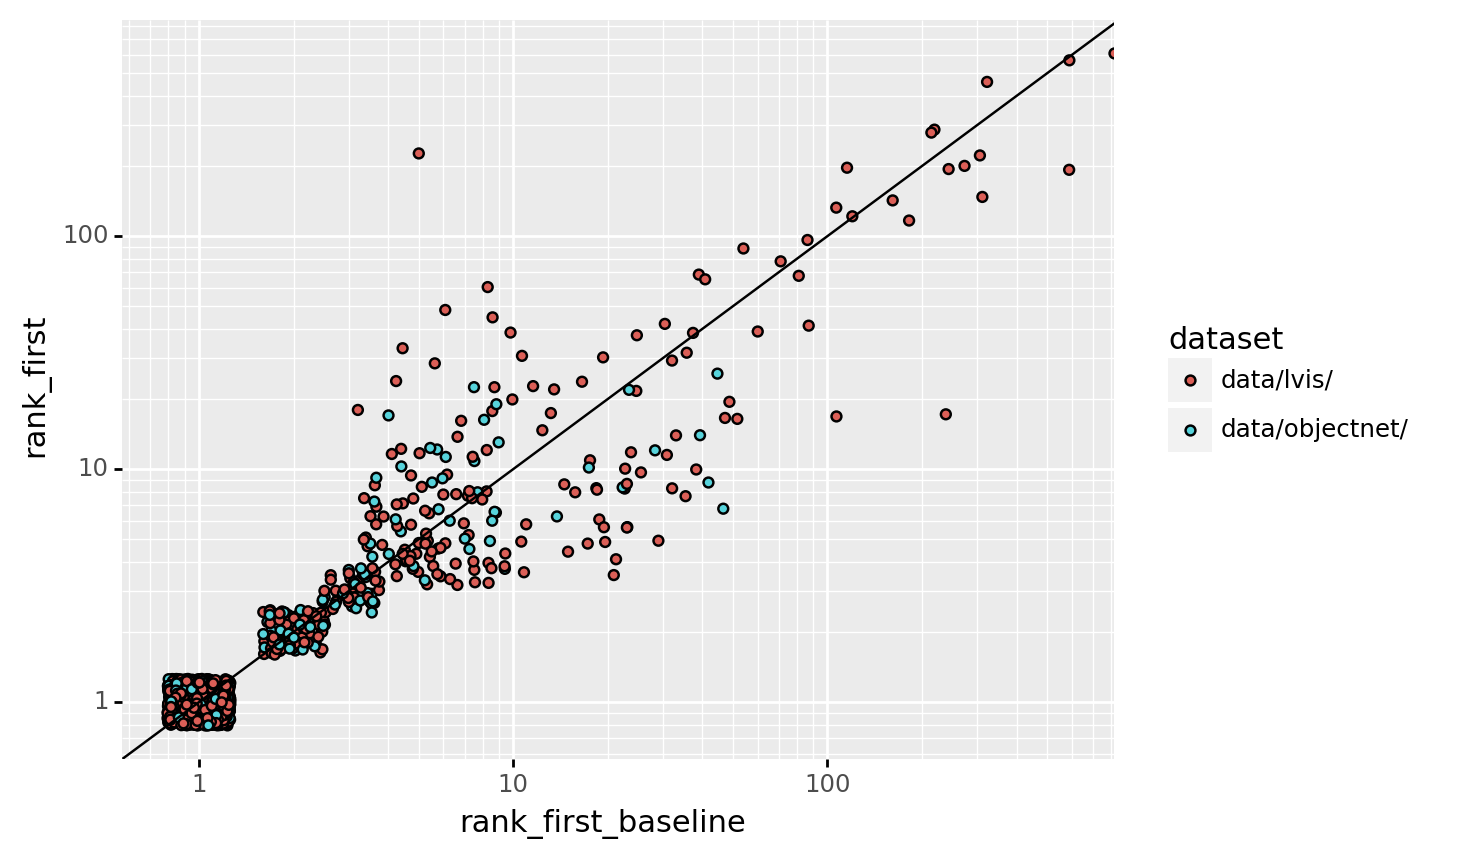

<ggplot: (8776983831799)>

In [18]:
plot = plot_compare(stats, 'textual_linear_with_agg_method', 'multi_with_agg_method', 'rank_first')
plot

In [19]:
interactive_compare(stats, 'textual_linear_with_agg_method', 'multi_with_agg_method', 'rank_first')

Loading BokehJS ...

2022-02-15 10:25:15,469	ERROR import_thread.py:89 -- ImportThread: Connection closed by server.
2022-02-15 10:25:15,472	ERROR worker.py:1247 -- listen_error_messages_raylet: Connection closed by server.


better  same  worse  neither  total
dataset                                             
data/lvis/          125  1000     78        0   1203
data/objectnet/      21   279     13        0    313
total               146  1279     91        0   1516

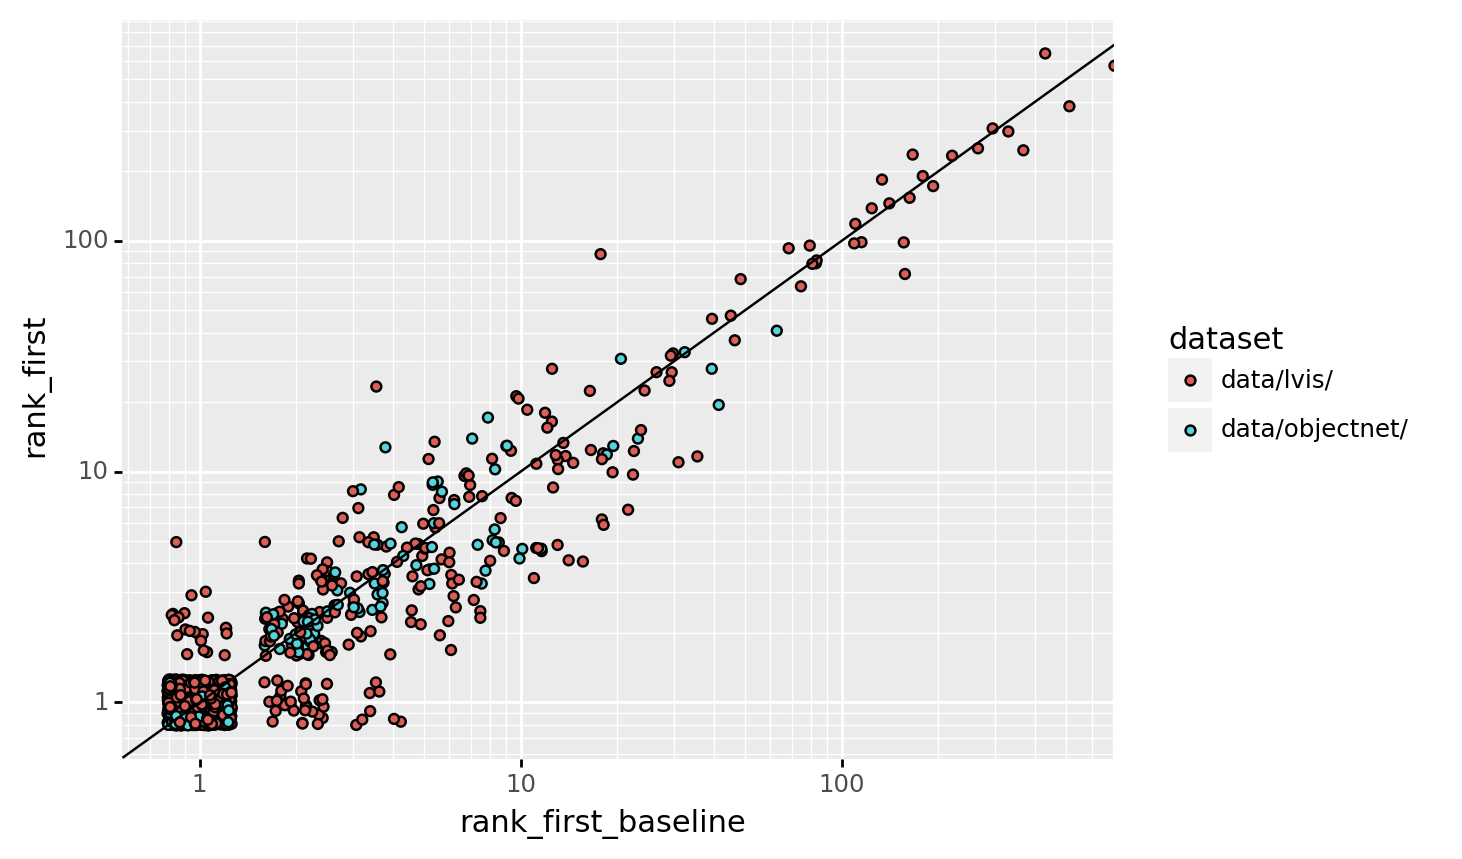

<ggplot: (8763380137469)>

In [22]:
plot = plot_compare(stats, 'textual_multi_temp_bias_only', 'seesaw_new_prompts', 'rank_first')
plot

In [30]:
interactive_compare(stats, 'textual_multi_temp_bias_only', 'multi_new_prompts', 'rank_first')

Loading BokehJS ...

bsw


better  same  worse  total
dataset                                    
data/lvis/          321   693    189   1203
data/objectnet/     127   139     47    313
total               448   832    236   1516

/state/partition1/llgrid/pkg/anaconda/anaconda3-2021b/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10


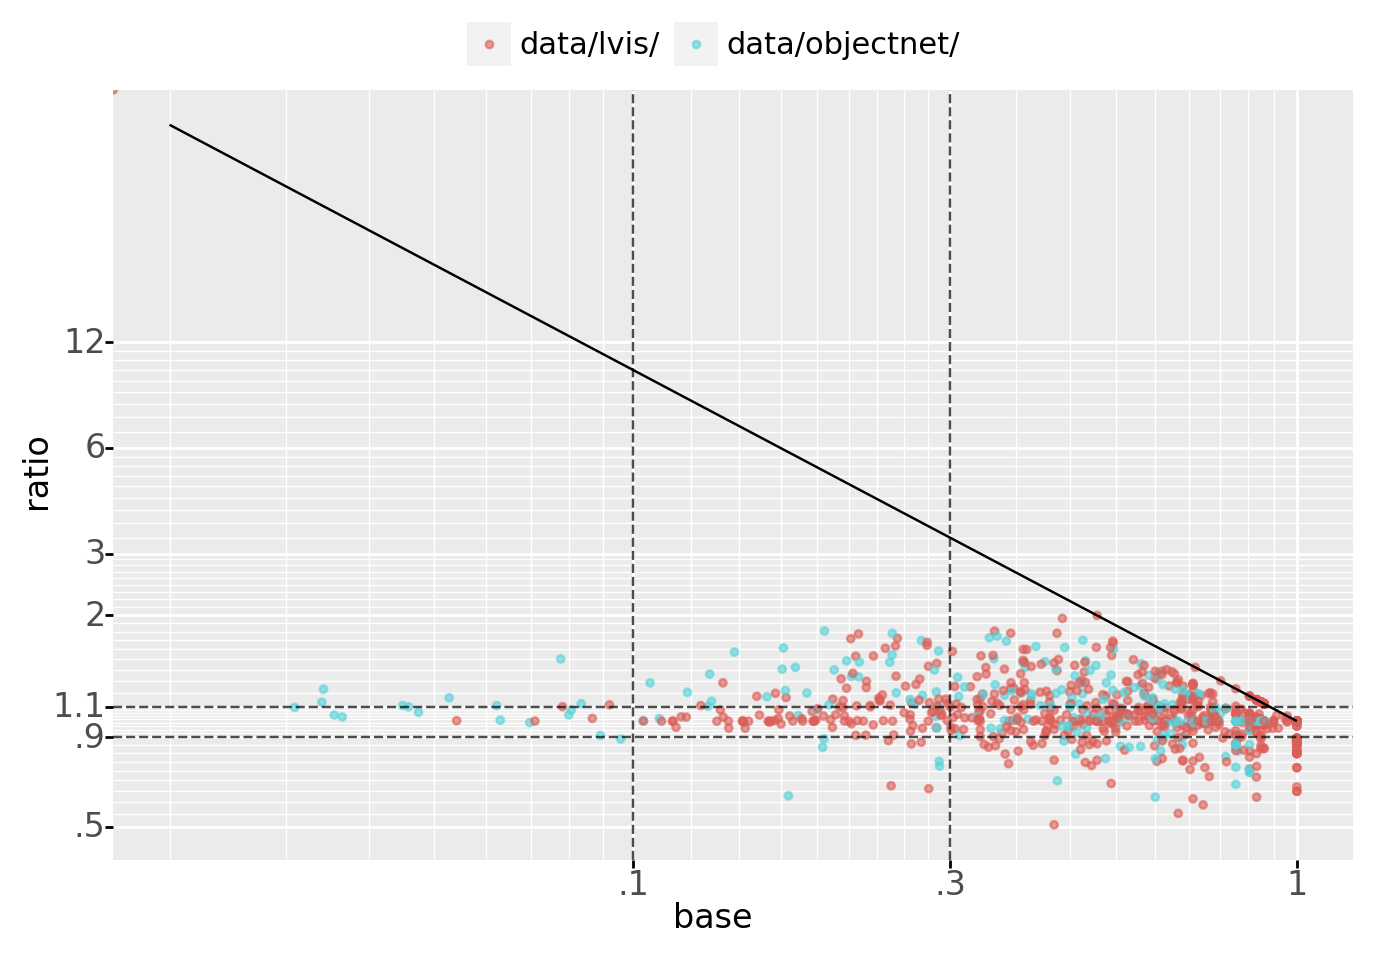

<ggplot: (8732731003308)>

{'by_dataset':                  baseline  baseline_new_prompts     multi  multi_less_zoom  \
 dataset                                                                      
 data/lvis/       0.691438              0.684683  0.783373         0.724868   
 data/objectnet/  0.625183              0.627815  0.624747              NaN   
 
                  multi_new_prompts    refine    seesaw  seesaw_less_zoom  \
 dataset                                                                    
 data/lvis/                0.771949  0.701634  0.794915           0.73532   
 data/objectnet/           0.627963  0.632683  0.632693               NaN   
 
                  seesaw_new_prompts  textual_multi  textual_multi_less_rounds  \
 dataset                                                                         
 data/lvis/                 0.786462       0.790802                   0.783996   
 data/objectnet/            0.637971       0.642933                   0.650250   
 
                  textual_mu

In [50]:
print_tables(stats, variant='textual_multi_temp_bias', baseline_variant='baseline_new_prompts',
             intermediate_variant='seesaw',
             metric='ndcg_score', reltol=1.02, brief=False)

/state/partition1/llgrid/pkg/anaconda/anaconda3-2021b/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10


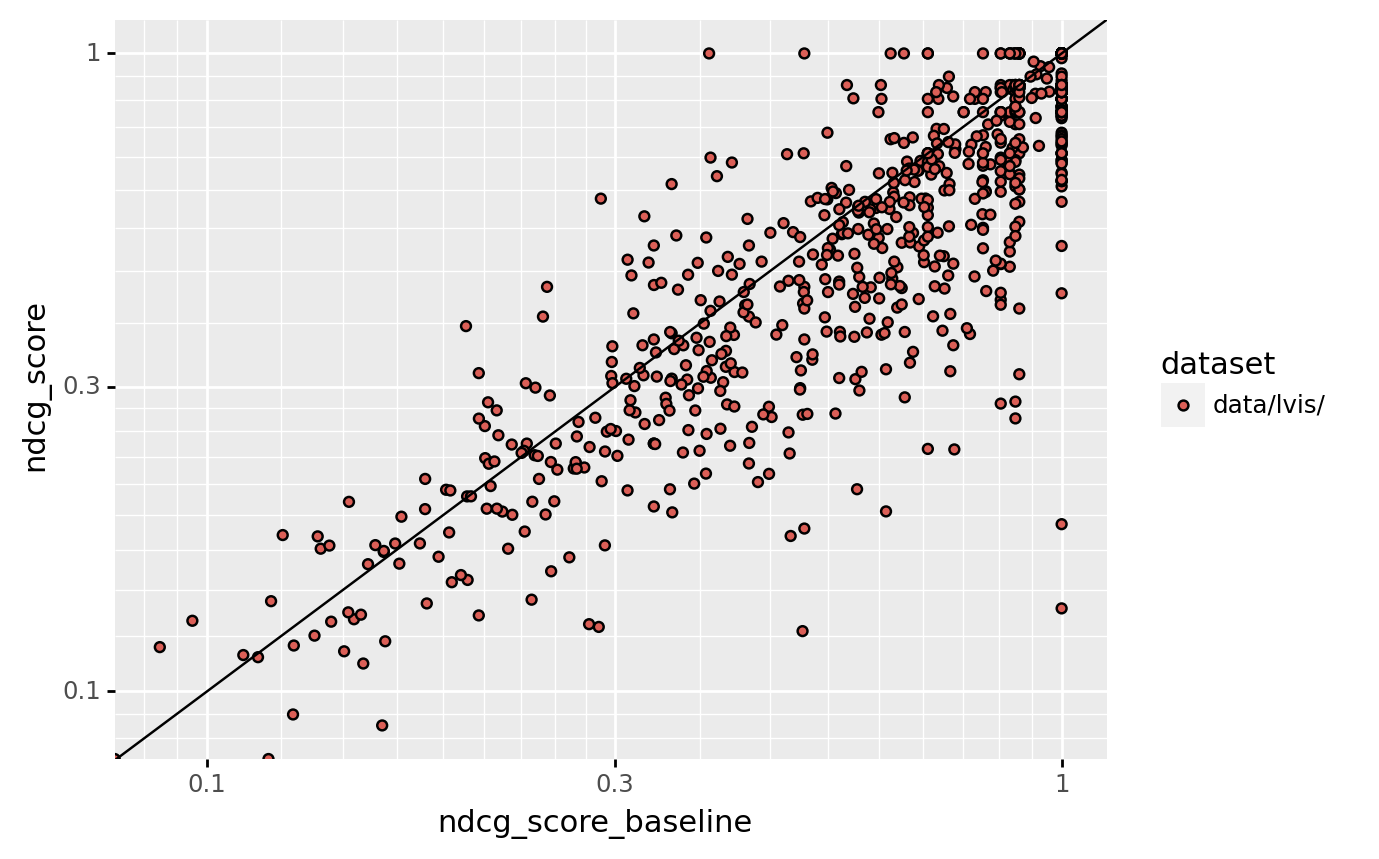

<ggplot: (8781108188630)>

In [32]:
# plot = compare(stats, 'seesaw_less_zoom', 'seesaw_new_prompts', 'ndcg_score')
# plot

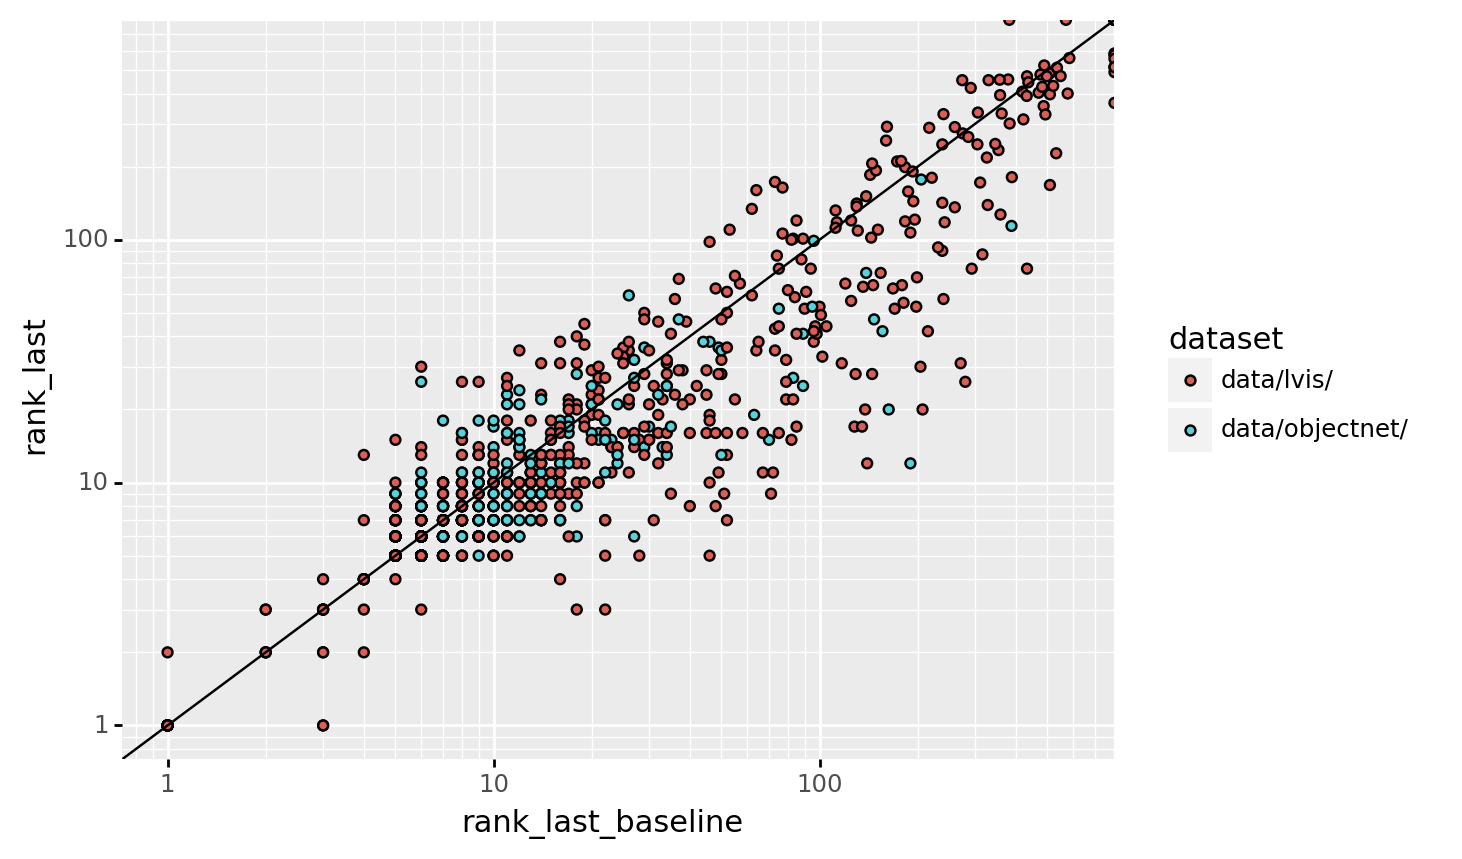

<ggplot: (8771713292023)>

In [144]:
plot = compare(stats, 'textual_multi_less_rounds', 'multi_new_prompts', 'rank_last')
plot

In [146]:
plotdata = plot.data

In [155]:
#plotdata.rank_last_baseline.is

In [158]:
((plotdata.rank_first == np.inf) & (plotdata.rank_first_baseline == np.inf)).sum()

0

In [160]:
(plotdata.rank_first - plotdata.rank_first_baseline).sort_values()

605      -inf
1318   -183.0
1154   -148.0
812    -133.0
506    -120.0
        ...  
813      74.0
1090     88.0
667     100.0
406     197.0
1121    283.0
Length: 1516, dtype: float64

In [161]:
(plotdata.rank_first - plotdata.rank_first_baseline).quantile([0,.001,.01, .1, .5, .9, .99, .999,1.])

/state/partition1/llgrid/pkg/anaconda/anaconda3-2021b/lib/python3.8/site-packages/numpy/lib/function_base.py:3963: RuntimeWarning: invalid value encountered in multiply


0.000        NaN
0.001   -164.975
0.010    -27.850
0.100     -1.000
0.500      0.000
0.900      1.000
0.990     18.000
0.999    147.045
1.000    283.000
dtype: float64

In [139]:
# compare(stats, 'multi_new_prompts', 'baseline_new_prompts', 'nAP')

In [ ]:
## takeaways: 
### if 

In [140]:
#stats.variant.unique()

bsw


better  same  worse  total
dataset                                    
data/lvis/          174   653    376   1203
data/objectnet/     125   100     88    313
total               299   753    464   1516

/state/partition1/llgrid/pkg/anaconda/anaconda3-2021b/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
/home/gridsan/omoll/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


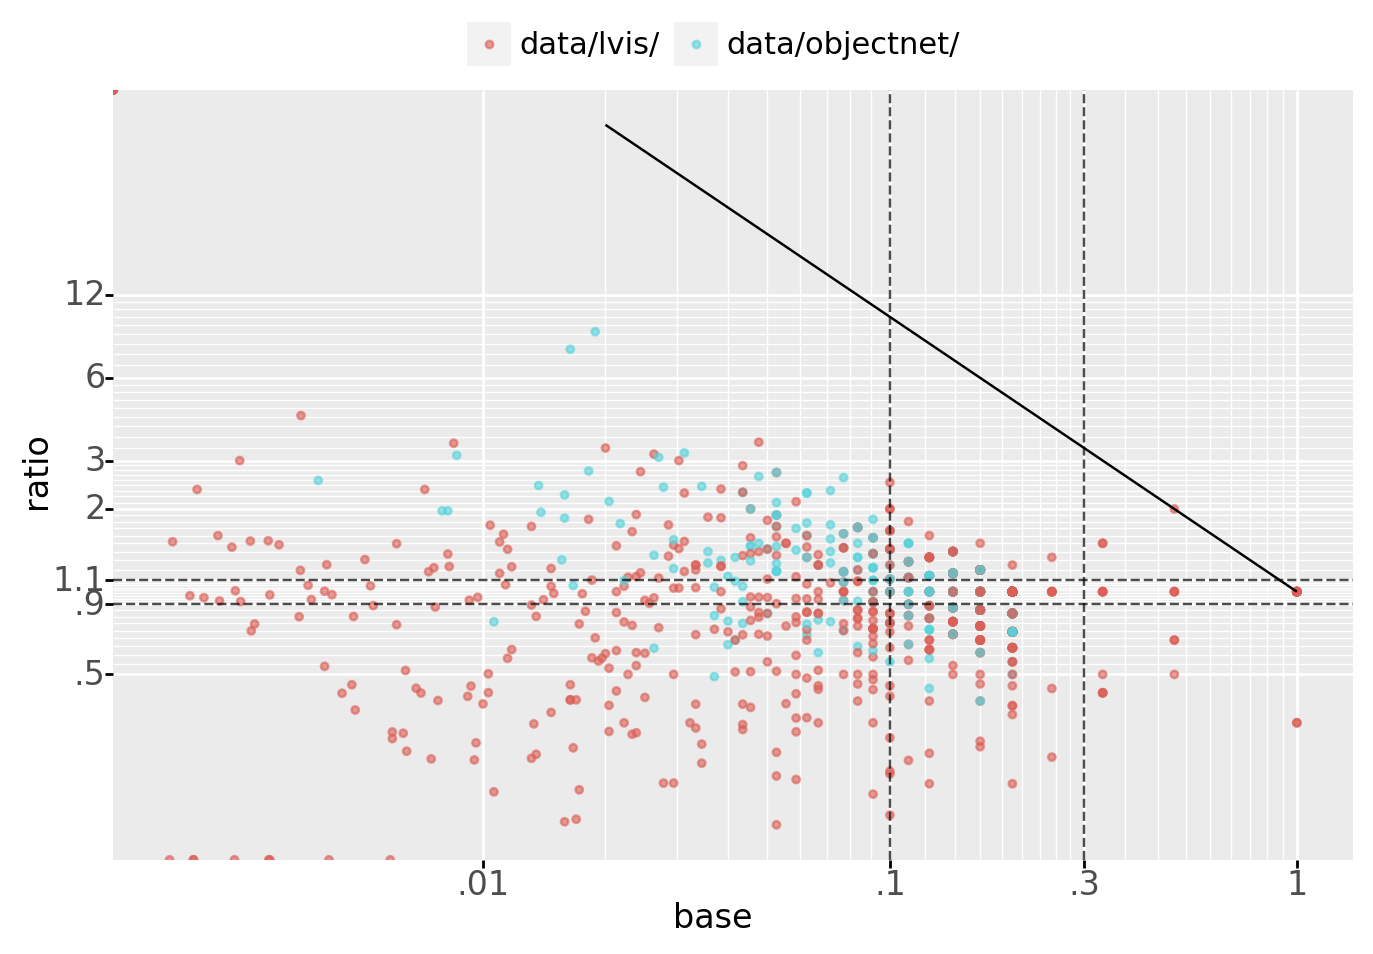

<ggplot: (8778975258001)>

In [41]:
metric='reciprocal_rank_last'
tabs = print_tables(stats,variant='textual_multi_margin01', baseline_variant='seesaw', metric=metric, reltol=1.05)

In [124]:
import bokeh
plotdata = tabs['plotdata']
pdata = plotdata[['x', 'y', 'dataset', 'category']]
#pdata = pd.merge(pdata, stats, left_on='session_index', right_on='')
pdata = pdata.assign(query_string = stats.query_string.values[plotdata.session_index.values])
pdata = pdata.assign(session_path = stats.session_path.values[plotdata.session_index.values])
pdata = pdata.assign(base_session_path = stats.session_path.values[plotdata.base_session_index.values])
pdata = pdata.assign(frequency = stats.frequency.values[plotdata.base_session_index.values])

In [125]:
interactive_scatterplot(pdata)

Loading BokehJS ...

In [27]:
from IPython.display import HTML
def session_link(session_path):
    return f"<a href='http://localhost/session/{session_path}'>{session_path}</a>"
# def comp(plotdata, dataset, category):
#     cols = ['variant', 'dataset', 'category', metric, 'nfirst','nfirst_batch', 'nfirst2second_batch', 'ntotal', 'session_path']
#     st = stats[(stats.dataset == dataset) & (stats.category == category)]
#     v = st[cols].set_index('variant')
#     v = v.loc[['plain', 'multiplain', 'seesaw']]
#     return HTML(v.to_html(escape=False, formatters=dict(session_path=session_link)))

In [28]:
stats

name ground_truth_category                 qstr  \
0             multi          still camera       a still camera   
1             multi       sling (bandage)      a sling bandage   
2            seesaw                 money              a money   
3     textual_multi                liquor             a liquor   
4            seesaw             saddlebag          a saddlebag   
...             ...                   ...                  ...   
6058          multi          weight scale       a weight scale   
6059         seesaw               pretzel            a pretzel   
6060         seesaw     coloring material  a coloring material   
6061         seesaw                  soup               a soup   
6062       baseline              backpack           a backpack   

      provide_textual_feedback  n_batches  max_results max_feedback  \
0                        False        200            5         None   
1                        False        200            5         None   
2                        False        200            5         None   
3                         True        200            5         None   
4                        False        200            5         None   
...                        ...        ...          ...          ...   
6058                     False        200            5         None   
6059                     False        200            5         None   
6060                     False        200            5         None   
6061                     False        200            5         None   
6062                     False        200            5         None   

      box_drop_prob           d_name      i_name  ... nseen nfirst ntotal  \
0               0.0  data/objectnet/  multiscale  ...     9    1.0    108   
1               0.0       data/lvis/  multiscale  ...     6    5.0      1   
2               0.0       data/lvis/  multiscale  ...     6    1.0     57   
3               0.0       data/lvis/  multiscale  ...    15    1.0      8   
4               0.0       data/lvis/  multiscale  ...     6    2.0     41   
...             ...              ...         ...  ...   ...    ...    ...   
6058            0.0  data/objectnet/  multiscale  ...     6    1.0    155   
6059            0.0       data/lvis/  multiscale  ...     9    1.0     22   
6060            0.0       data/lvis/  multiscale  ...   567   94.0      2   
6061            0.0       data/lvis/  multiscale  ...     6    1.0    191   
6062            0.0       data/lvis/      coarse  ...     6    1.0   2302   

     reciprocal_rank          dataset  index_name           category  \
0           1.000000  data/objectnet/  multiscale       still camera   
1           0.200000       data/lvis/  multiscale    sling (bandage)   
2           1.000000       data/lvis/  multiscale              money   
3           1.000000       data/lvis/  multiscale             liquor   
4           0.500000       data/lvis/  multiscale          saddlebag   
...              ...              ...         ...                ...   
6058        1.000000  data/objectnet/  multiscale       weight scale   
6059        1.000000       data/lvis/  multiscale            pretzel   
6060        0.010638       data/lvis/  multiscale  coloring material   
6061        1.000000       data/lvis/  multiscale               soup   
6062        1.000000       data/lvis/      coarse           backpack   

             query_string        variant  missed_all  
0          a still camera     multiplain       False  
1         a sling bandage     multiplain       False  
2                 a money         seesaw       False  
3                a liquor  textual_multi       False  
4             a saddlebag         seesaw       False  
...                   ...            ...         ...  
6058       a weight scale     multiplain       False  
6059            a pretzel         seesaw       False  
6060  a coloring material         seesaw       False  
6061               a soup    

In [ ]:
# conclusion:  some objectnet cases are truly harder to debug.
## should we expect things to get better from one example? not if the example is misleading, or if
# the clustering is diffuse.

### we may want to avoid randomness effects from one sample by regularizing.
### 1. weight averaging?
### 2. difference decay

### effect of commonality: am I confusing class with something far more common.
### alternative plans: use classifier for more than just fine-tuning.

## v1*s1 

## the last thing we did was reduce the margin. this may be generally a good idea: we really just want 
## the right tag to be scored better. A lot of dot products between vectors are already probably small.